# Estimate Neural Manifold Immersion

## Set Up + Imports

In [238]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Synthetic circle analysis

In [312]:
task_points, intrinsic_coords = synthetic.hypersphere(1, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array([5, 3, 1]),
    fano_factor=0.1,
)

In [313]:
from neurometry.estimators.geometry.immersion_estimator import ImmersionEstimator

extrinsic_dim = 3
topology = "circle"
device = "cuda"

immersion_estimator = ImmersionEstimator(
    extrinsic_dim, topology, device=device, verbose=True
)

latents = immersion_estimator.intrinsic_to_extrinsic(intrinsic_coords).squeeze()

In [314]:
immersion_estimator.fit(X=latents, y=noisy_points)

Epoch 1/200, Train Loss: 13022.06607155235, Test Loss: 11866.508007193383
Epoch 2/200, Train Loss: 8618.303601918711, Test Loss: 4035.902180384047
Epoch 3/200, Train Loss: 3506.947428379754, Test Loss: 2918.8028884944165
Epoch 4/200, Train Loss: 2998.2627454944236, Test Loss: 2960.5285708899637
Epoch 5/200, Train Loss: 2943.1006402080316, Test Loss: 2854.7209811061157
Epoch 6/200, Train Loss: 2931.749965913282, Test Loss: 2906.7113782873034
Epoch 7/200, Train Loss: 2936.539423533661, Test Loss: 2869.982490885765
Epoch 8/200, Train Loss: 2924.5017225906395, Test Loss: 2927.270978193271
Epoch 9/200, Train Loss: 2925.263847975524, Test Loss: 2780.0403350470656
Epoch 10/200, Train Loss: 2921.043327633271, Test Loss: 2839.904050959253
Epoch 11/200, Train Loss: 2905.3423914164487, Test Loss: 2866.2912308967966
Epoch 12/200, Train Loss: 2876.427814198662, Test Loss: 2829.4151015565185
Epoch 13/200, Train Loss: 2779.8973905041703, Test Loss: 2673.4944191285686
Epoch 14/200, Train Loss: 2228.94

ImmersionEstimator(device='cuda', extrinsic_dim=3, topology='circle',
                   verbose=True)

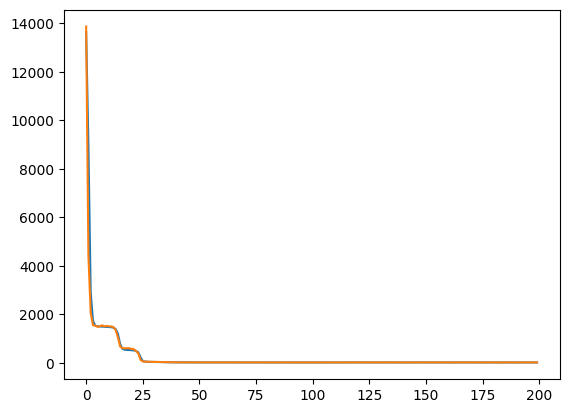

In [267]:
plt.plot(immersion_estimator.trainer.train_losses)
plt.plot(immersion_estimator.trainer.test_losses);

In [303]:
immersion_estimator.model.to("cpu")
immersion = immersion_estimator.estimate_

In [269]:
intrinsic_coords = torch.tensor(intrinsic_coords, device=device)

recon_points = immersion(intrinsic_coords).detach().cpu().numpy().squeeze()

In [270]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# plot manifold points in 3d and recon points in 3d in separate subplots

colors = intrinsic_coords.detach().cpu().numpy().squeeze()

fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
    subplot_titles=("Noisy Points", "Manifold Points", "Reconstructed Points"),
)

fig.add_trace(
    go.Scatter3d(
        x=noisy_points[:, 0],
        y=noisy_points[:, 1],
        z=noisy_points[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter3d(
        x=manifold_points[:, 0],
        y=manifold_points[:, 1],
        z=manifold_points[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter3d(
        x=recon_points[:, 0],
        y=recon_points[:, 1],
        z=recon_points[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=3,
)

fig.show()

In [305]:
from neurometry.estimators.geometry.metric_estimator import NeuralManifoldIntrinsic

circle_neural_manifold = NeuralManifoldIntrinsic(
    dim=1, neural_embedding_dim=extrinsic_dim, neural_immersion=immersion, equip=True
)

In [306]:
point_a = gs.array([0]).unsqueeze(0)
point_b = gs.array([0.5]).unsqueeze(0)
circle_neural_manifold.metric.dist(point_a, point_b)

RuntimeError: The Tensor returned by the function given to hessian should contain a single element

In [307]:
from geomstats.geometry.pullback_metric import PullbackMetric

circle_neural_manifold = NeuralManifoldIntrinsic(
    dim=1, neural_embedding_dim=extrinsic_dim, neural_immersion=immersion, equip=False
)
circle_neural_manifold.equip_with_metric(PullbackMetric);

## Synthetic Torus analysis

In [315]:
task_points, intrinsic_coords = synthetic.hypertorus(2, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=4,
    nonlinearity="sigmoid",
    scales=gs.array([5, 3, 1, 3]),
    fano_factor=1,
)

In [317]:
from neurometry.estimators.geometry.immersion_estimator import ImmersionEstimator

extrinsic_dim = 4
topology = "torus"
device = "cuda"

immersion_estimator = ImmersionEstimator(extrinsic_dim, topology, device=device)

latents = immersion_estimator.intrinsic_to_extrinsic(intrinsic_coords).squeeze()

In [318]:
immersion_estimator.fit(X=latents, y=noisy_points)

ImmersionEstimator(device='cuda', extrinsic_dim=4, topology='torus')

In [320]:
immersion = immersion_estimator.estimate_

intrinsic_coords = torch.tensor(intrinsic_coords, device=device)
colors = intrinsic_coords.detach().cpu().numpy().squeeze()
recon_points = immersion(intrinsic_coords).detach().cpu().numpy().squeeze()

In [321]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
noisy_points_pca = pca.fit_transform(noisy_points)

manifold_points_pca = pca.transform(manifold_points)

recon_points_pca = pca.transform(recon_points)

colors = colors[:, 1]

fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
)

fig.add_trace(
    go.Scatter3d(
        x=noisy_points_pca[:, 0],
        y=noisy_points_pca[:, 1],
        z=noisy_points_pca[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter3d(
        x=manifold_points_pca[:, 0],
        y=manifold_points_pca[:, 1],
        z=manifold_points_pca[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter3d(
        x=recon_points_pca[:, 0],
        y=recon_points_pca[:, 1],
        z=recon_points_pca[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
    ),
    row=1,
    col=3,
)

fig.show()